Задача определения вероятности возврата покупки.

In [1]:
# обработка данных
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import numpy as np
import random as rnd

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling

# моделирование
from catboost import CatBoostClassifier

# оценка
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('D:\\Work\\data\\agregator\\train.csv')
test = pd.read_csv('D:\\Work\\data\\agregator\\test.csv')

### 1. EDA

In [3]:
# склеиваем вместе трейн и тест

full_data = pd.concat([train, test], ignore_index=True)
full_data.head()

,orderid,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
0,0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0
1,1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
4,4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0


Все переменные анонимные, сложная история.

In [4]:
full_data.describe()

,orderid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
count,651067.000000,651067.000000,6.510670e+05,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.00000,6.510670e+05,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000
mean,188515.401787,28.415045,-5.718477e-16,7.978630,7.867928,3.747118,0.556672,1.577236,1.263658,0.879828,0.023683,0.447739,14.616669,11.989201,27.30533,-1.354570e-16,1.518057,15.631981,2.993680,3.808444,2.075998,3.989258,1.226731,39.004728,13.045100,1.406829,4.878449,3.899232,1.751784,0.087546,2.980225,0.994985,0.979761,0.348374,0.645238,0.647944,0.036627,0.168579,0.038713,0.022519,0.015098,0.022142
std,128647.670301,69.704182,1.000000e+00,2.754209,3.010155,18.094611,0.496778,5.573744,0.440616,0.325163,0.163779,0.497262,5.525271,19.690783,58.13627,1.000000e+00,0.965593,25.436819,8.508684,1.932545,0.978270,1.976828,0.418717,73.999480,6.132659,0.798080,11.625625,4.254252,1.379756,0.369092,0.919228,0.070638,0.140817,0.476456,0.478442,0.477612,0.187845,0.374381,0.192912,0.148365,0.121942,0.147144
min,0.000000,0.000000,-8.592222e-01,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,-9.414412e-01,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,81383.000000,0.000000,-4.713654e-01,6.000000,6.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,11.000000,4.000000,3.00000,-5.212421e-01,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,162766.000000,0.000000,-2.386513e-01,8.000000,8.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,15.000000,5.000000,4.00000,-2.411093e-01,1.000000,6.000000,1.000000,4.000000,2.000000,4.000000,1.000000,17.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,292243.500000,13.000000,1.492055e-01,10.000000,10.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,19.000000,11.000000,26.00000,1.790899e-01,2.000000,18.000000,1.000000,5.000000,3.000000,6.000000,1.000000,42.000000,18.000000,2.000000,1.000000,5.000000,3.000000,0.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,455010.000000,507.000000,8.214213e+01,12.000000,12.000000,756.000000,1.000000,344.000000,2.000000,1.000000,4.000000,1.000000,23.000000,316.000000,928.00000,5.522518e+01,18.000000,340.000000,179.000000,7.000000,9.000000,7.000000,2.000000,1049.000000,23.000000,18.000000,193.000000,30.000000,7.000000,16.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# количество уникальных значений в столбцах

un = {}
for i in full_data.columns:
    un[i] = len(full_data[i].unique())

un = pd.DataFrame.from_dict(un, orient='index', columns=['count'])
un = un.sort_values('count', ascending=False)
un

,count
orderid,455011
userid,378449
field22,1050
field13,929
field4,756
field0,503
field16,332
field1,317
field12,316
field6,212


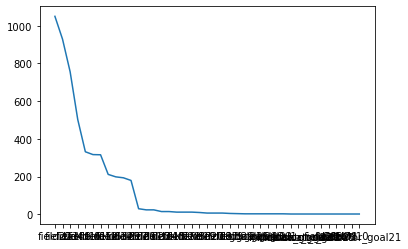

In [6]:
# вариативность переменных, кроме orderid и userid

plt.plot(un.index[2:], un.values[2:])

In [7]:
# какие именно уникальные значения в каждом поле

for i in full_data.columns:
    print(i, ": ", full_data[i].unique())

orderid :  [     0      1      2 ... 455008 455009 455010]
userid :  ['10d654494cbe97bbb25d51ead2600679aff9e097924add09d8066010a0c9adaf'
 '4aafc0391f72bbcf60537aece62923baf9ce644b64ac365a75e021cca794b91b'
 'bac8ffef46348f587c8d17137ab01fb24aef21547c647d2ea68a0214c8abf003' ...
 '5af2c8b53a965915f496971f0f105393f7f9c9b0931e6b9710a83832a99bf6a3'
 '255bfc6ac2f9c98d7f86e59bd72a682e7a50c2db6107495fabd8729471cc172e'
 '58a0463aea3ece956b49099380c17cf1d3dd591b70e58c080600920c51af9b9a']
field0 :  [  0 144 134 156  33  52 181  48  28   2   5  45 229  40  53  95   1   7
  54  23  59 369 115   4  61  22 114 220   3  14  76  20 288  34  87 240
  30 117 146 119 176  57 139  81   8 226  79 120  19 191  29  13  63   6
 445 324  68  38  50  10 228  21  82  44  55 138 148  91 415 130  42  74
  25 382 315 183 365 153  60 287  12 351  16  86  27 313 322  11 133  83
 294  26 152  15   9  46 205  18  73 232 233 123  37  36 383 111 135 126
 106 109  75  99 352 171 207 159  35  56 368 194  77 227 389 163 204  

field28 :  [ 0  1  2  3  4  8  6  5  7 10 14 16]
field29 :  [4 2 1 3]
indicator_goal21 :  [1 0]
indicator_goal22 :  [1 0]
indicator_goal23 :  [0 1]
indicator_goal24 :  [1 0]
indicator_goal25 :  [1 0]
goal21 :  [ 0.  1. nan]
goal22 :  [ 1.  0. nan]
goal23 :  [ 0.  1. nan]
goal24 :  [ 0.  1. nan]
goal25 :  [ 0.  1. nan]
goal1 :  [ 0.  1. nan]


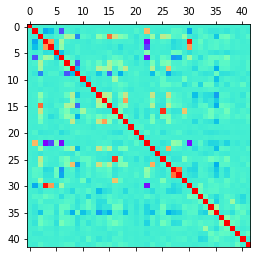

In [8]:
# матрица корреляций переменных

plt.matshow(full_data.corr(), cmap='rainbow')

In [9]:
# все группировки по признаку заказа и заказу

train_goal1 = train[train['goal1'] == 1] # вернувшие билет
train_goal0 = train[train['goal1'] == 0] # не вернувшие билет
train_goal1[['indicator_goal21', 'indicator_goal22', 'indicator_goal23','indicator_goal24', 'indicator_goal25',
             'goal21', 'goal22', 'goal23','goal24', 'goal25', 'goal1']].groupby(['indicator_goal21', 
            'indicator_goal22', 'indicator_goal23','indicator_goal24', 'indicator_goal25', 'goal1']).count()

goal21  \
indicator_goal21 indicator_goal22 indicator_goal23 indicator_goal24 indicator_goal25 goal1           
0                0                0                0                1                1           3   
                 1                0                0                0                1          15   
                                                                    1                1           2   
                                                   1                0                1          12   
                                  1                0                0                1           4   
                                                   1                0                1           6   
1                0                0                0                1                1           3   
                                                   1                0                1           2   
                                                                    1                1          54   
                 1                0                0                0                1         490   
                                                                    1                1         303   
                                                   1                0                1         441   
                                                                    1                1        1477   
                                  1                0                0                1         204   
                                                                    1                1         138   
                                                   1                0                1         557   
                                                                    1                1         630   

                                                                                            goal22  \
indicator_goal21 indicator_goal22 indicator_goal23 indicator_goal24 indicator_goal25 goal1           
0                0                0                0                1                1           3   
                 1                0                0                0                1          15   
                                                                    1                1           2   
                                                   1                0                1          12   
                                  1                0                0                1           4   
                                                   1                0                1           6   
1                0                0                0                1                1           3   
                                                   1                0                1           2   
                                                                    1                1          54   
                 1                0                0                0                1         490   
                                                                    1                1         303   
                                                   1                0                1         441   
                                                                    1                1        1477   
                                  1                0                0                1         204   
                                                                    1                1         138   
                                                   1                0                1         557   
                                                                    1                1         630   

                                                                                            goal23  \
indicator_goal21 indicator_goal22 indicator_goal23 indicator_goal24 indicator_goal25 goal1           
0         

In [10]:
# видим сильный дисбаланс классов

train['goal1'].value_counts(normalize=False) 

0    191715
1      4341
Name: goal1, dtype: int64

### 2. Очистка и подготовка данных

In [11]:
# для goal1:

X_train = train.iloc[:, 2:37] # все столбы кроме orderid, userid и целевой goal1
Y_train = train.iloc[:, 42] # целевая goal1
X_test = test.iloc[:, 2:37]

print('For train:', X_train.shape,Y_train.shape,X_test.shape)

For train: (196056, 35) (196056,) (455011, 35)


In [12]:
# для goal1:
# часть трейна как проверочная:

X_train1 = train.iloc[:156844, 2:37] # все столбы кроме orderid, userid и целевой goal1
Y_train1 = train.iloc[:156844, 42] # целевая goal1
X_test1 = train.iloc[156844:, 2:37] # тест из общей
Y_test1 = train.iloc[156844:, 42] # ответ к тесту из общей

print('For train/test:', X_train1.shape, Y_train1.shape, X_test1.shape, Y_test1.shape)

For train/test: (156844, 35) (156844,) (39212, 35) (39212,)


In [13]:
train.head()

,orderid,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
0,0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0
1,1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0
2,2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0
3,3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0
4,4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0


Обучим модель catboost:

In [14]:
# CatBoost для goal1

cbc = CatBoostClassifier(random_state=13, n_estimators=500, custom_metric='AUC', learning_rate=0.075, 
                         bootstrap_type='MVS',  bagging_temperature=0.9, mvs_reg=0.95, leaf_estimation_method='Gradient', 
                         od_type='Iter', silent=True) 
cbc.fit(X_train1, Y_train1)
Y_pred = cbc.predict(X_test1)
cbc.score(X_train1, Y_train1)
acc_cbc = round(cbc.score(X_train1, Y_train1) * 100, 9)
y_score = cbc.fit(X_train1, Y_train1).predict_proba(X_test1)[:, 1]
auc_cbc = roc_auc_score(Y_test1, y_score) 
auc_cbc 

0.6835529600963445

Посмотрим вес переменных:

In [15]:
# сортировка переменных по значимости в моделях

colu_cbc = X_train1.columns
features = cbc.feature_importances_
feat_imp_cbc = dict(zip(colu_cbc, features))
feat_imp_cbc = pd.DataFrame(feat_imp_cbc, index = range(1)).T.sort_values([0], ascending=False)
#feat_imp_cbc

feat_imp = pd.concat([feat_imp_cbc], axis = 1, sort = False)
feat_imp.columns = ['feat_imp_cbc']
feat_imp

,feat_imp_cbc
field16,18.003476
field12,12.229555
field14,5.404374
field6,4.974547
field25,4.382041
field22,4.072311
field1,3.796554
field13,3.464042
field11,3.020030
field3,2.978868


In [16]:
# кросс-валидация Catboost:

cross_val_score(estimator = cbc, X=X_train1, y=Y_train1, cv = 10, scoring='roc_auc').mean()

0.6819034066218197

Предскажем и сохраним:

In [17]:
y_pred = cbc.predict_proba(X_test)

pd.DataFrame(y_pred[:, 1], columns=['proba'], index=test['orderid']).to_csv('D:\\Work\\data\\agregator\\cbc.csv')